In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os 
import pandas as pd
from PIL import Image
import seaborn as sns 
import matplotlib.pyplot as plt
import plotly.express as px
import plotly

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten,Input,ZeroPadding2D,BatchNormalization,Activation
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall
from tensorflow.keras.layers.experimental import preprocessing


from sklearn.metrics import classification_report

In [2]:
# the r in front of the string converts it to a raw string
folder_path = r"C:/Users/Darin Tsui/Documents/COGS 118b/Proj"
No_Tumor_Img = os.listdir(folder_path + '/no/')
Tumor_Img = os.listdir(folder_path + '/yes/')

In [3]:
Classes = {'no':0, 'yes':1}

In [5]:
X = []
y = []
for i in Classes:
    path = r"C:/Users/Darin Tsui/Documents/COGS 118b/Proj/"+i
    for j in os.listdir(path):
        img = cv2.imread(path+'/'+j, 0)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # use the process function to crop the brain and ignore the unnecessary rest part of the image
        
        # resize image
        img = cv2.resize(img, (128,128),interpolation=cv2.INTER_CUBIC)
        # normalize values
        #img = img / 255  #-->Apply normalization because we want pixel values to be scaled to the range 0-1
        X.append(img)
        y.append(Classes[i])

In [6]:
no_image_pixels = []
yes_image_pixels = []
for j in range(len(y)):
    if y[j] == 0:
        no_image_pixels.append(X[j])
    else:
        yes_image_pixels.append(X[j])

In [7]:
# Convert to numpy array 
no_image_pixels_array = np.asarray(no_image_pixels)
yes_image_pixels_array = np.asarray(yes_image_pixels)
no_image_pixels_array = no_image_pixels_array.reshape(98,16384)
yes_image_pixels_array = yes_image_pixels_array.reshape(155,16384)

In [55]:
# Train PCA on 25% of dataset
X_no_train, X_no_test = train_test_split(no_image_pixels_array, test_size = 0.75, random_state = 69)
X_no_test = X_no_test.reshape(74,128,128)
print(X_no_test.shape)
X_no_train = X_no_train.T
print(X_no_train.shape)

X_yes_train, X_yes_test = train_test_split(yes_image_pixels_array, test_size = 0.75, random_state = 69)
print(X_yes_test.shape)
X_yes_test = X_yes_test[0:116,:]
X_yes_test = X_yes_test.reshape(116,128,128)
print(X_yes_test.shape)
X_yes_train = X_yes_train.T
print(X_yes_train.shape)

# y train, binary option tumor or no tumor
y_no = np.asarray(y[0:98])
y_yes = np.asarray(y[99:254])
y_no_train, y_no_test = train_test_split(y_no, test_size = 0.75, random_state = 12)
y_yes_train, y_yes_test = train_test_split(y_yes, test_size = 0.75, random_state = 12)
print(y_no_test.shape)
print(y_yes_test.shape)

(74, 128, 128)
(16384, 24)
(117, 16384)
(116, 128, 128)
(16384, 38)
(74,)
(116,)


In [9]:
# Standardization function
def standardize(X):
    # Calculate the mean of each column mu
    mu = np.mean(X,axis=0)
    
    # Subtract the mean from X
    X = X - mu
    
    # Calculate standard deviation of each column
    std = np.std(X,axis=0)
    
    # Handle zero standard deviation case
    std_filled = std.copy()
    std_filled[std==0] = 1.0
    
    # Calculate standardized X
    X_bar = (X-mu)/std_filled
    
    return X_bar, mu, std


In [10]:
# Function to calculate eigenvectors and eigenvalues
def eig(S):
    eig_vec, eig_val = np.linalg.eigh(S)
    # sorting eigenvalues in decreasing order
    # np.argsort returns indices of positions 
    sorted_eig = np.argsort(-eig_val)
    eig_val = eig_val[sorted_eig]
    eig_vec = eig_vec[sorted_eig]
    
    return (eig_vec, eig_val)
    

In [11]:
# Function to calculate projection matrix for reconstruction
def projection(A):
    M = A @ A.T
    return M

In [12]:
## Implement PCA
def PCA(X,mu, num_pcs):
    # Calculate the covariance matrix
    dim = np.shape(X)
    avg = np.tile(np.array([X.mean(axis=1)]).T, (1,dim[1])) 
    Z = X - avg
    N = dim[1]
    cov_matrix = Z.T.dot(Z) / N
    
    # Find eigenvalue and eigenvectors of covariance matrix
    eig_vecs, eig_vals = eig(cov_matrix)
    
    # Select specific eigenvectors
    U = Z.dot(eig_vecs)
    U = U / U.max(axis=0)
    return U

In [21]:
no_pixel_mu = no_image_pixels_array.mean().mean()
yes_pixel_mu = no_image_pixels_array.mean().mean()
x_no_reconstruction = PCA(X_no_train, no_pixel_mu, 5)
x_yes_reconstruction = PCA(X_yes_train, yes_pixel_mu, 5)
x_no_reconstruction.T.shape
x_no_reconstruction = x_no_reconstruction.reshape(24,128,128)
x_no_reconstruction = x_no_reconstruction.reshape(-1,128,128,1)

x_yes_reconstruction = x_yes_reconstruction.reshape(38,128,128)
x_yes_reconstruction = x_yes_reconstruction.reshape(-1,128,128,1)
x_yes_reconstruction.shape
X_yes_test.shape

(116, 128, 128)

In [14]:
# CNN Model

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=64,
                           kernel_size=3,
                           activation='relu',
                           input_shape=(128,128,1)),
    tf.keras.layers.Conv2D(32,(4,4),activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2),
                              padding='valid'),
    tf.keras.layers.Conv2D(32,(4,4),activation='relu'),
    tf.keras.layers.Conv2D(16,3,activation='relu'),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 123, 123, 32)      32800     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 61, 61, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 58, 58, 32)        16416     
                                                                 
 conv2d_3 (Conv2D)           (None, 56, 56, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 28, 16)       0         
 2D)                                                    

In [32]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [30]:
# Combine training and test sets
x_reconstruction = np.concatenate((x_no_reconstruction, x_yes_reconstruction), axis=0)
y_train = np.concatenate((y_no_train, y_yes_train), axis=0)
X_test = np.concatenate((X_no_test, X_yes_test), axis=0)
y_test = np.concatenate((y_no_test, y_yes_test), axis=0)

In [33]:
model.fit(x=x_reconstruction, y=y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
2/2 [==============================] - 7s 4s/step - loss: 0.6841 - accuracy: 0.5968 - val_loss: 33.0643 - val_accuracy: 0.6105
Epoch 2/10
2/2 [==============================] - 6s 4s/step - loss: 0.6633 - accuracy: 0.6129 - val_loss: 43.5819 - val_accuracy: 0.6105
Epoch 3/10
2/2 [==============================] - 5s 4s/step - loss: 0.6158 - accuracy: 0.6129 - val_loss: 24.2350 - val_accuracy: 0.6105
Epoch 4/10
2/2 [==============================] - 6s 4s/step - loss: 0.5932 - accuracy: 0.6129 - val_loss: 37.2396 - val_accuracy: 0.6105
Epoch 5/10
2/2 [==============================] - 5s 4s/step - loss: 0.5283 - accuracy: 0.6129 - val_loss: 67.0884 - val_accuracy: 0.6105
Epoch 6/10
2/2 [==============================] - 5s 3s/step - loss: 0.4674 - accuracy: 0.6129 - val_loss: 49.9078 - val_accuracy: 0.6105
Epoch 7/10
2/2 [==============================] - 5s 3s/step - loss: 0.3633 - accuracy: 0.7581 - val_loss: 57.7604 - val_accuracy: 0.6105
Epoch 8/10
2/2 [==================

In [34]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

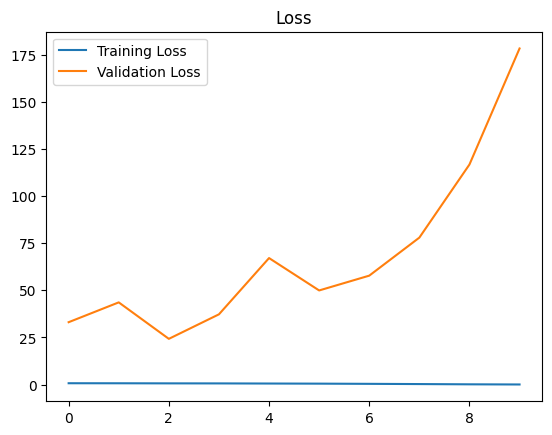

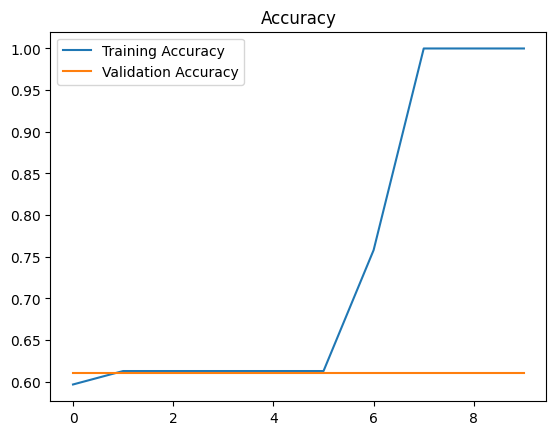

In [35]:
history = model.history.history
model_loss=pd.DataFrame(model.history.history)
plot_metrics(history)

In [36]:
# Train PCA on 50% of dataset
X_no_50_train, X_no_50_test = train_test_split(no_image_pixels_array, test_size = 0.5, random_state = 69)
X_no_50_test = X_no_50_test.reshape(49,128,128)
print(X_no_50_test.shape)
X_no_50_train = X_no_50_train.T
print(X_no_50_train.shape)

X_yes_50_train, X_yes_50_test = train_test_split(yes_image_pixels_array, test_size = 0.5, random_state = 69)
#print(X_yes_test.shape)
X_yes_50_test = X_yes_50_test.reshape(78,128,128)
X_yes_50_test = X_yes_50_test[0:77,:,:]
print(X_yes_50_test.shape)
X_yes_50_train = X_yes_50_train.T
print(X_yes_50_train.shape)

# y train, binary option tumor or no tumor
y_no = np.asarray(y[0:98])
y_yes = np.asarray(y[99:254])
y_no_50_train, y_no_50_test = train_test_split(y_no, test_size = 0.5, random_state = 12)
y_yes_50_train, y_yes_50_test = train_test_split(y_yes, test_size = 0.5, random_state = 12)
print(y_no_50_test.shape)
print(y_yes_50_test.shape)

(49, 128, 128)
(16384, 49)
(77, 128, 128)
(16384, 77)
(49,)
(77,)


In [40]:
x_no_50_reconstruction = PCA(X_no_50_train, no_pixel_mu, 5)
x_no_50_reconstruction = x_no_50_reconstruction.T
x_no_50_reconstruction = x_no_50_reconstruction.reshape(49, 128, 128)
print(x_no_50_reconstruction.shape)
x_yes_50_reconstruction = PCA(X_yes_50_train, yes_pixel_mu, 5)
x_yes_50_reconstruction = x_yes_50_reconstruction.T
x_yes_50_reconstruction = x_yes_50_reconstruction.reshape(77,128,128)
print(x_yes_50_reconstruction.shape)

(49, 128, 128)
(77, 128, 128)


In [41]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [42]:
# Combine training and test sets
x_reconstruction = np.concatenate((x_no_50_reconstruction, x_yes_50_reconstruction), axis=0)
y_train = np.concatenate((y_no_50_train, y_yes_50_train), axis=0)
X_test = np.concatenate((X_no_50_test, X_yes_50_test), axis=0)
y_test = np.concatenate((y_no_50_test, y_yes_50_test), axis=0)

In [43]:
model.fit(x=x_reconstruction, y=y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
4/4 [==============================] - 10s 2s/step - loss: 1.1233 - accuracy: 0.4921 - val_loss: 265.3539 - val_accuracy: 0.3889
Epoch 2/10
4/4 [==============================] - 7s 2s/step - loss: 0.6962 - accuracy: 0.5952 - val_loss: 24.3736 - val_accuracy: 0.6270
Epoch 3/10
4/4 [==============================] - 8s 2s/step - loss: 0.6106 - accuracy: 0.6270 - val_loss: 17.6383 - val_accuracy: 0.6905
Epoch 4/10
4/4 [==============================] - 9s 2s/step - loss: 0.5495 - accuracy: 0.8730 - val_loss: 73.2588 - val_accuracy: 0.4524
Epoch 5/10
4/4 [==============================] - 8s 2s/step - loss: 0.4667 - accuracy: 0.8730 - val_loss: 43.9023 - val_accuracy: 0.7063
Epoch 6/10
4/4 [==============================] - 8s 2s/step - loss: 0.3698 - accuracy: 0.8175 - val_loss: 116.7739 - val_accuracy: 0.5635
Epoch 7/10
4/4 [==============================] - 7s 2s/step - loss: 0.2931 - accuracy: 0.9286 - val_loss: 229.6790 - val_accuracy: 0.5159
Epoch 8/10
4/4 [==============

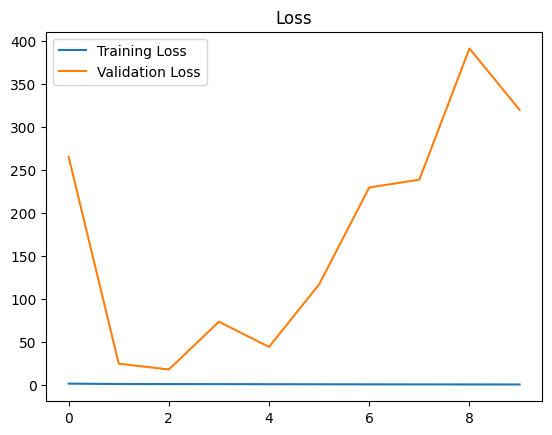

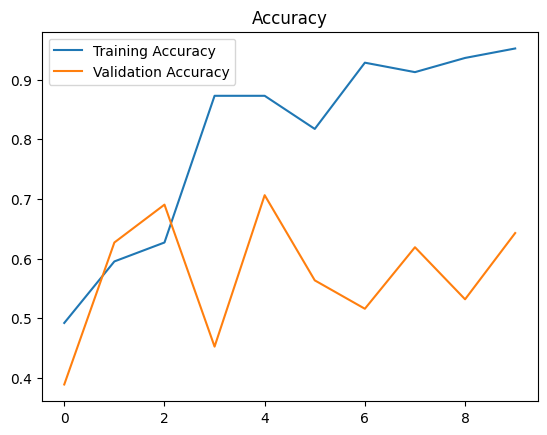

In [44]:
history = model.history.history
model_loss=pd.DataFrame(model.history.history)
plot_metrics(history)

In [46]:
# Train PCA on 75% of dataset
X_no_75_train, X_no_75_test = train_test_split(no_image_pixels_array, test_size = 0.25, random_state = 69)
X_no_75_test = X_no_75_test.reshape(25,128,128)
print(X_no_75_test.shape)
X_no_75_train = X_no_75_train.T
print(X_no_75_train.shape)

X_yes_75_train, X_yes_75_test = train_test_split(yes_image_pixels_array, test_size = 0.25, random_state = 69)
X_yes_75_test = X_yes_75_test.reshape(39,128,128)
print(X_yes_75_test.shape)
X_yes_75_train = X_yes_75_train.T
print(X_yes_75_train.shape)

# y train, binary option tumor or no tumor
y_no_75_train, y_no_75_test = train_test_split(y_no, test_size = 0.25, random_state = 12)
y_yes_75_train, y_yes_75_test = train_test_split(y_yes, test_size = 0.25, random_state = 12)
print(y_no_75_test.shape)
print(y_yes_75_train.shape)

(25, 128, 128)
(16384, 73)
(39, 128, 128)
(16384, 116)
(25,)
(115,)


In [47]:
x_no_75_reconstruction = PCA(X_no_75_train, no_pixel_mu, 5)
x_no_75_reconstruction = x_no_75_reconstruction.T
x_no_75_reconstruction = x_no_75_reconstruction.reshape(73, 128, 128)
print(x_no_75_reconstruction.shape)
x_yes_75_reconstruction = PCA(X_yes_75_train, yes_pixel_mu, 5)
x_yes_75_reconstruction = x_yes_75_reconstruction.T
x_yes_75_reconstruction = x_yes_75_reconstruction.reshape(116,128,128)
x_yes_75_reconstruction = x_yes_75_reconstruction[0:115,:,:]
print(x_yes_75_reconstruction.shape)

(73, 128, 128)
(115, 128, 128)


In [49]:
# Combine training and test sets
x_reconstruction = np.concatenate((x_no_75_reconstruction, x_yes_75_reconstruction), axis=0)
y_train = np.concatenate((y_no_75_train, y_yes_75_train), axis=0)
X_test = np.concatenate((X_no_75_test, X_yes_75_test), axis=0)
y_test = np.concatenate((y_no_75_test, y_yes_75_test), axis=0)

In [50]:
# Run model on 75% no data
model.fit(x=x_reconstruction, y=y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
6/6 [==============================] - 11s 2s/step - loss: 0.1477 - accuracy: 0.9628 - val_loss: 283.8596 - val_accuracy: 0.6250
Epoch 2/10
6/6 [==============================] - 10s 2s/step - loss: 0.1108 - accuracy: 0.9787 - val_loss: 297.2378 - val_accuracy: 0.6250
Epoch 3/10
6/6 [==============================] - 10s 2s/step - loss: 0.0891 - accuracy: 0.9681 - val_loss: 310.3271 - val_accuracy: 0.6094
Epoch 4/10
6/6 [==============================] - 10s 2s/step - loss: 0.0614 - accuracy: 0.9787 - val_loss: 505.0492 - val_accuracy: 0.5781
Epoch 5/10
6/6 [==============================] - 11s 2s/step - loss: 0.0684 - accuracy: 0.9840 - val_loss: 186.6877 - val_accuracy: 0.7656
Epoch 6/10
6/6 [==============================] - 10s 2s/step - loss: 0.0696 - accuracy: 0.9681 - val_loss: 377.6307 - val_accuracy: 0.5938
Epoch 7/10
6/6 [==============================] - 11s 2s/step - loss: 0.0490 - accuracy: 0.9894 - val_loss: 228.6259 - val_accuracy: 0.7500
Epoch 8/10
6/6 [====

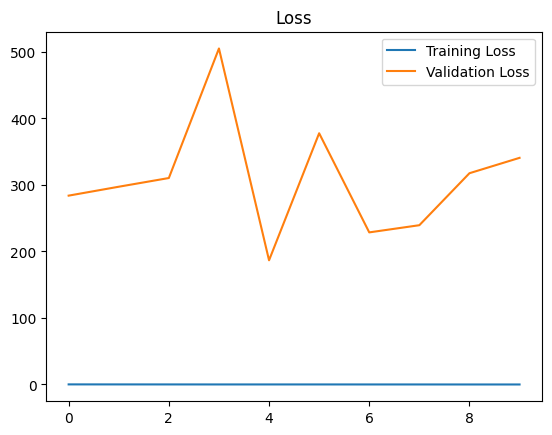

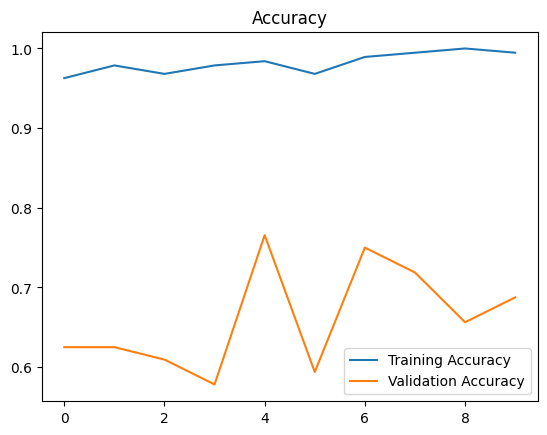

In [56]:
history = model.history.history
model_loss=pd.DataFrame(model.history.history)
plot_metrics(history)